In [85]:
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import csv

images = []
for file in glob.glob("Alg2.0%w WP 10cSt/*.bmp"):
    #print(file)
    image = cv2.imread(file)
    images.append(image)

print(f'number of image found:{len(images)}')
h, w, c= images[0].shape
print(f'width: {w} height: {h} channels: {c}')



number of image found:9
width: 288 height: 440 channels: 3


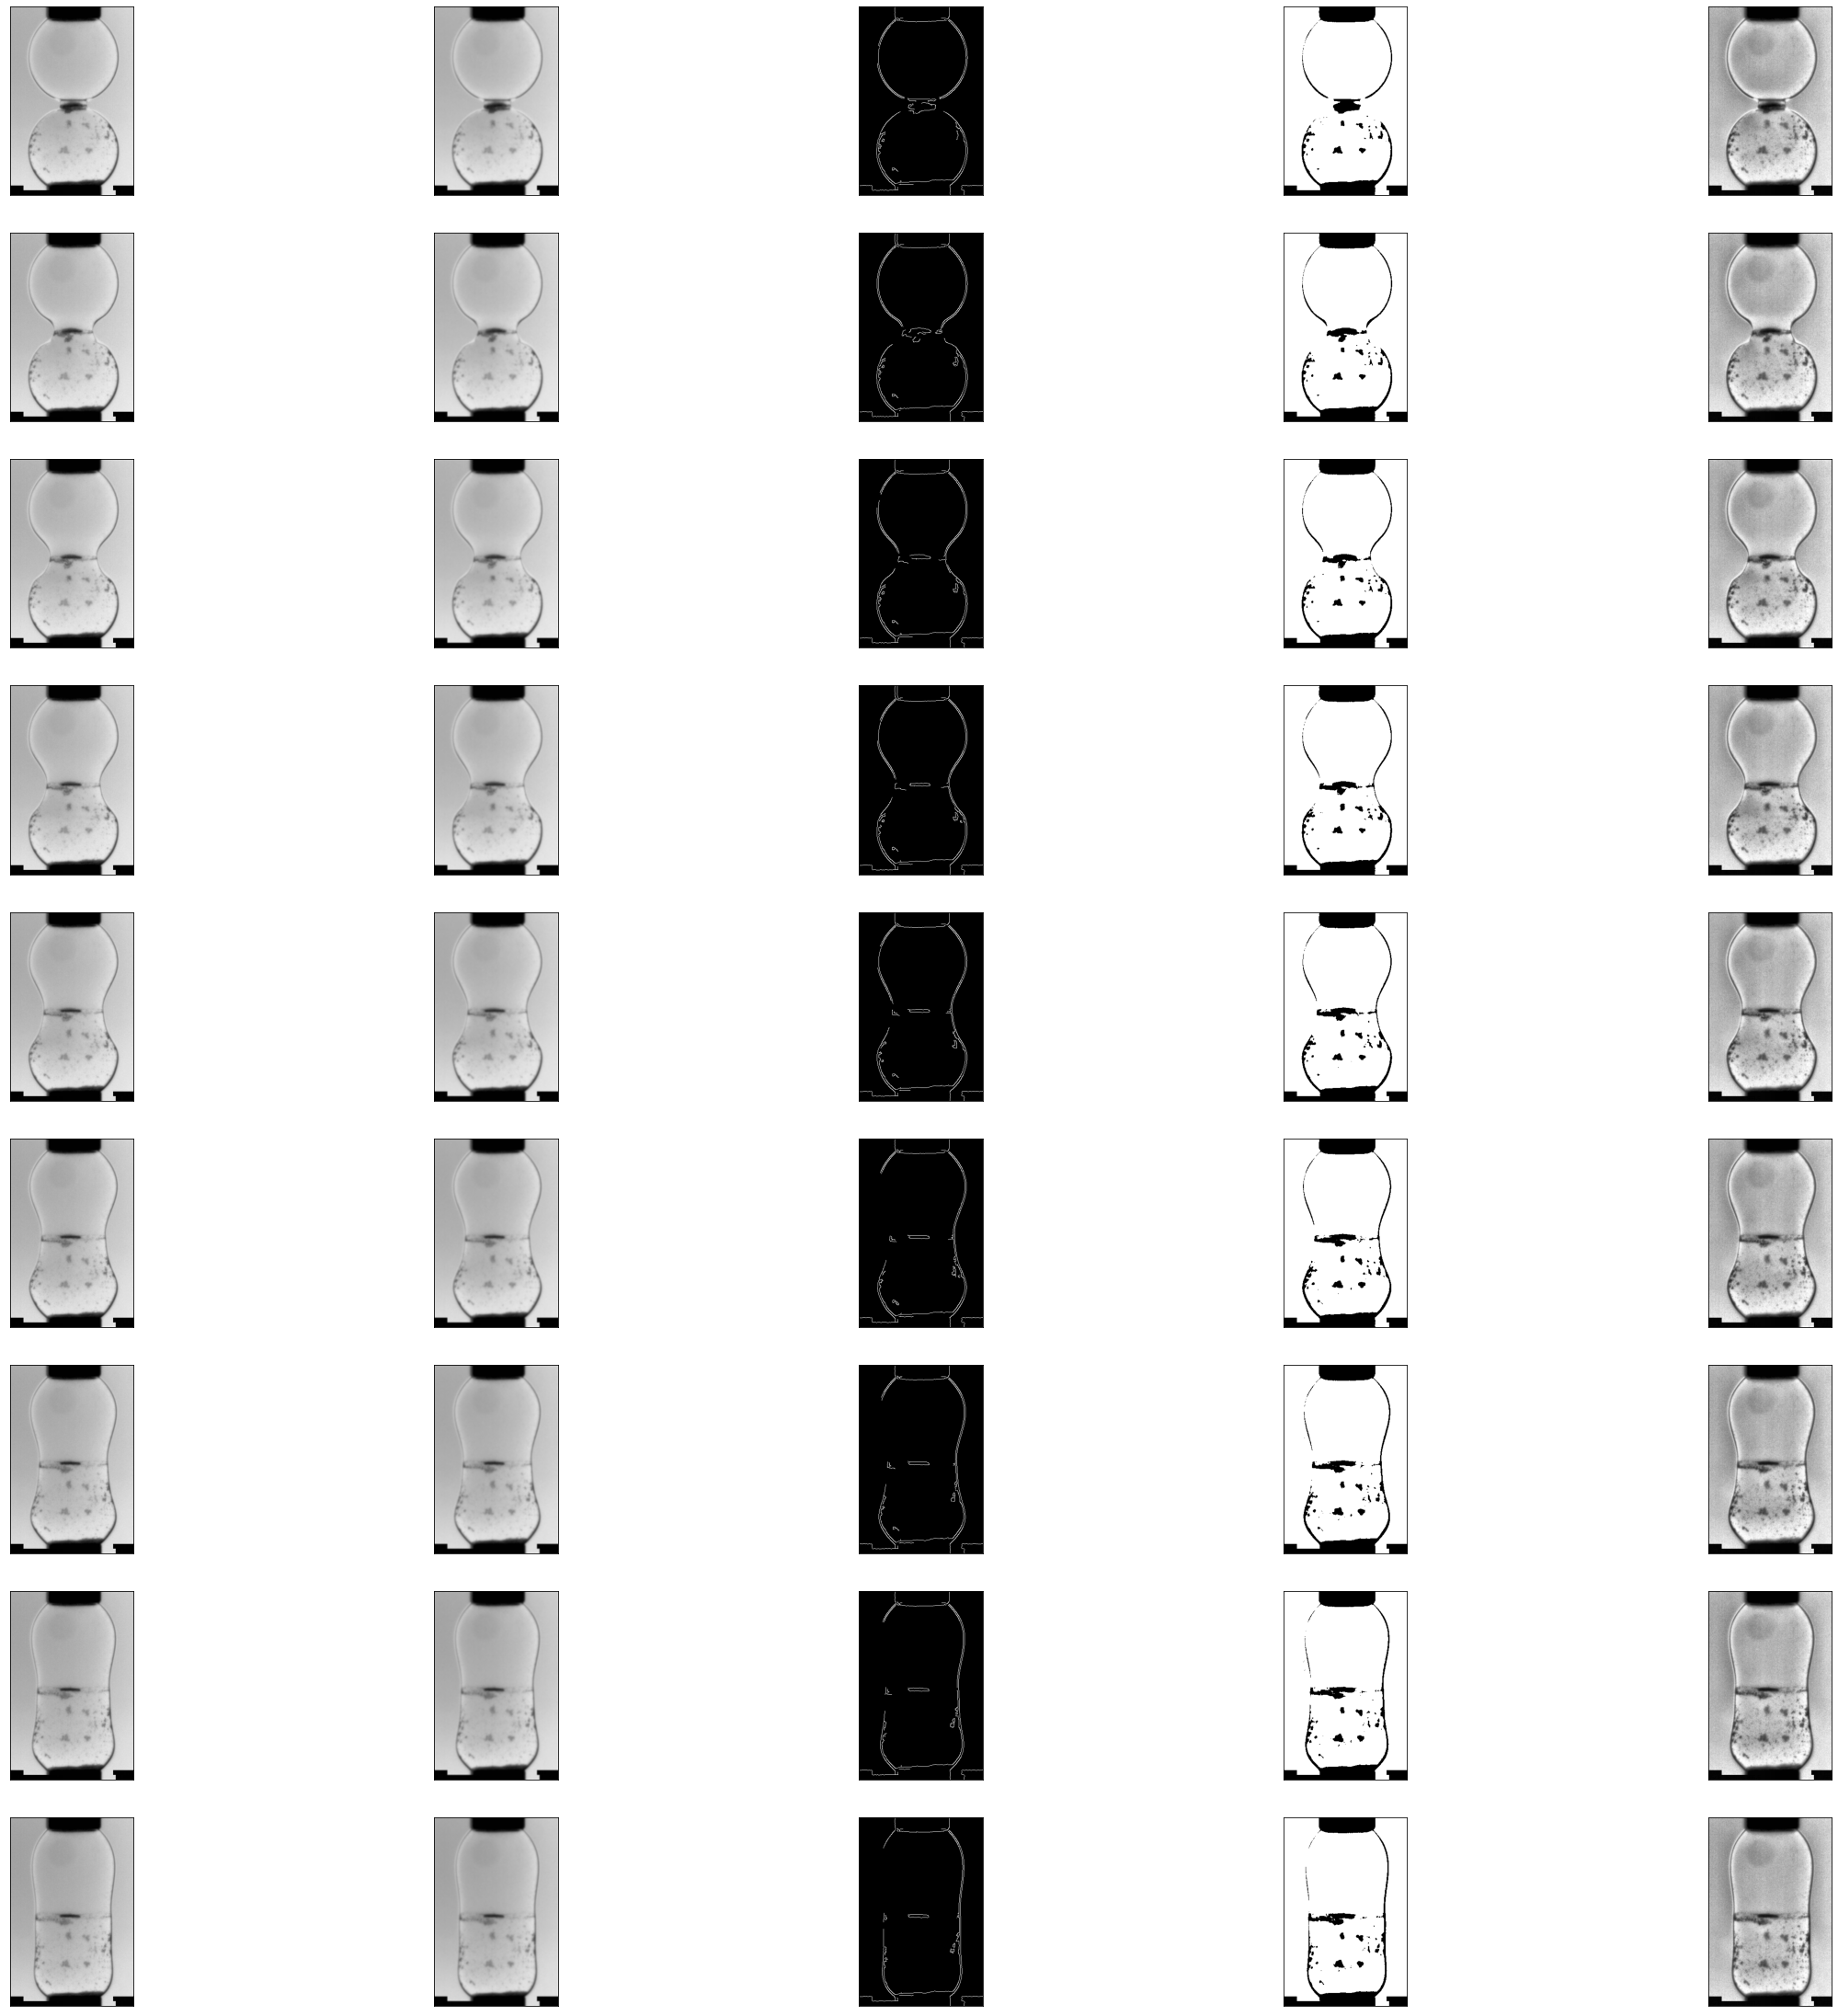

In [87]:
imgs_edges = []
imgs_thresh = []
z = 0
fig = plt.figure(figsize=(40, 40))
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))

for i in images:
    b = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
    #r,g,b = cv2.split(i)
    cl = clahe.apply(b)
    
    blur = cv2.GaussianBlur(i,(5,5),0)
    edges_canny = cv2.Canny(cl,100,200)
    imgs_edges.append(edges_canny)
    

    
    ret,thresh = cv2.threshold(b,120,255,cv2.THRESH_BINARY)
    imgs_thresh.append(thresh)
    images_plot = [i, blur,edges_canny,thresh,cl]
    #titles = ['Original Image','GaussianBlur','Canny','BINARY','clahe']
    

    for j in range(5):
        plt.subplot(len(images),5,z*5+j+1),plt.imshow(images_plot[j],'gray')
        #plt.title(titles[j])
        plt.xticks([]),plt.yticks([])
    z += 1
    i += 1
#plt.show()

In [83]:
img_select = 2
img_edges = imgs_edges[img_select]
img_thresh = imgs_thresh[img_select]

h, w, c = images[img_select].shape
print(f'width: {w} height: {h} channels: {c}')
h, w, c = img_thresh.shape
print(f'width: {w} height: {h} channels: {c}')
h, w = img_edges.shape
print(f'width: {w} height: {h}')

width: 288 height: 440 channels: 3


ValueError: not enough values to unpack (expected 3, got 2)

In [84]:
#generate droplets width array
indices = np.where(img_edges != [0])
width = []

for row in range(0,439):
    edge_l = 0
    edge_r = 0
    for col in range(0,140):
        if(img_edges[row,col]!=[0]):
            edge_l = col
            break
    for col in range(1,140):
        _col = 288 - col
        if(img_edges[row,_col]!=[0]):
            edge_r = _col
            break
    _width = edge_r - edge_l
    if(_width>0):
        width.append(_width)
    else:
        width.append(0)

filter_length = 8
tair_moving_average = np.convolve(width,np.ones((filter_length)),mode='same')
tair_moving_average /= filter_length
width = tair_moving_average

#Bridge width detection and measurment
edge_vertical = []
row_bridgeLoc = 0
for row in range(100,439):
    edge_top = 0
    edge_bottom = 0
    #edge_vertical.append(thresh1[row,140,0])
    if(img_thresh[row,140,0]==[0]):
        edge_top = row
        y=0
        while y < 50:
            _row = row + 50 - y
            y += 1
            if(img_thresh[_row,140,0]==[0]):
                edge_bottom = _row
                break
        row_bridgeLoc = round(edge_top + (edge_bottom - edge_top)/2)
        print(f'top: {edge_top} bottom: {edge_bottom} bridge: {row_bridgeLoc}')
        break

for col in range(0,140):
    if(img_edges[row_bridgeLoc,col]!=[0]):
        edge_l = col
        break
for col in range(1,140):
    _col = 288 - col
    if(img_edges[row_bridgeLoc,_col]!=[0]):
        edge_r = _col
        break
width_bridge = edge_r - edge_l
#width_bridge = width[row_bridgeLoc]

#----determine pixel to mm conversion coefficient----
conversion_factor = 13.2 / width[0]

#Deterine droplet diameter
peaks,_ = find_peaks(width,height=140)

arr = np.asarray(peaks) #print("Array is : ", arr)
row_topDropletMax = row_bridgeLoc / 2
row_bottomDropletMax = row_bridgeLoc + row_bridgeLoc / 2 # element to which nearest value is to be found
difference_array = np.absolute(arr-row_topDropletMax) # calculate the difference array
index_top = difference_array.argmin() # find the index of minimum element from the array
difference_array = np.absolute(arr-row_bottomDropletMax) # calculate the difference array
index_bottom = difference_array.argmin() # find the index of minimum element from the array
print("Value to which nearest element is to be found: ", row_topDropletMax)
print("Nearest element to the given values is : ", arr[index_top])
print("Value to which nearest element is to be found: ", row_bottomDropletMax)
print("Nearest element to the given values is : ", arr[index_bottom])

print(f'Top Droplet Diameter: {width[arr[index_top]]} Bottom Droplet Diameter: {width[arr[index_bottom]]}')
print(f'Conversion coefficient (pixel to mm): {conversion_factor}')
print(f'Bridge width: {width_bridge}')
peak_x = []
i = 0
while i < len(peaks):
    peak_x.append(width[peaks[i]])
    i += 1

top_edge_l = 0
top_edge_r = 0
for col in range(0,140):
    if(img_edges[arr[index_top],col]!=[0]):
        top_edge_l = col
        break
for col in range(1,140):
    _col = 288 - col
    if(img_edges[arr[index_top],_col]!=[0]):
        top_edge_r = _col
        break

bottom_edge_l = 0
bottom_edge_r = 0
for col in range(0,140):
    if(img_edges[arr[index_bottom],col]!=[0]):
        bottom_edge_l = col
        break
for col in range(1,140):
    _col = 288 - col
    if(img_edges[arr[index_bottom],_col]!=[0]):
        bottom_edge_r = _col
        break
        
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
plt.plot(width)
plt.plot(peaks,peak_x,"x")
plt.subplot(2,2,2)
plt.plot(indices[0],indices[1])
plt.subplot(2,2,3)
plt.imshow(img_thresh)

plt.subplot(2,2,4)
plt.plot([edge_l,edge_r],[row_bridgeLoc,row_bridgeLoc],"x")
plt.plot([top_edge_l,top_edge_r],[arr[index_top],arr[index_top]],"x")
plt.plot([bottom_edge_l,bottom_edge_r],[arr[index_bottom],arr[index_bottom]],"x")
plt.imshow(images[img_select])

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [5]:
with open('test_file.csv',mode = 'w') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow( ['Image No','Bridge Diameter','Droplet Diamter (top)','Droplet Diameter (bottom)'])
    csv_writer.writerow([img_select,width_bridge,width[arr[index_top]],width[arr[index_bottom]]])